# Sex-Specific Alzheimer's Disease Modelling Experimentations

## Data Set-up

In [49]:
# === Load and clean data ===
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy import stats
import random
from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt


In [50]:
# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [51]:
# Load OASIS dataset
df = pd.read_csv("oasis_longitudinal.csv")

## Initial Data Exploration and Cleaning

In [53]:
# Display simple attributes
df.head()
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [54]:
# Check for missing values
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [55]:
# Check for duplicates
df.duplicated().sum()

0

In [56]:
# Fill missing SES and MMSE values
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())

In [57]:
# Convert labels to binary classification: demented = 1, nondemented = 0
df['Group'] = df['Group'].replace("Converted", "Demented")
df['Group'] = df['Group'].map({"Demented": 1, "Nondemented": 0})

In [58]:
# Define features and dropping missing values
my_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
df_clean = df.dropna(subset=my_features + ['Group', 'M/F'])

In [59]:
pd.crosstab(df['M/F'], df['Group'])

Group,0,1
M/F,,
F,129,84
M,61,99


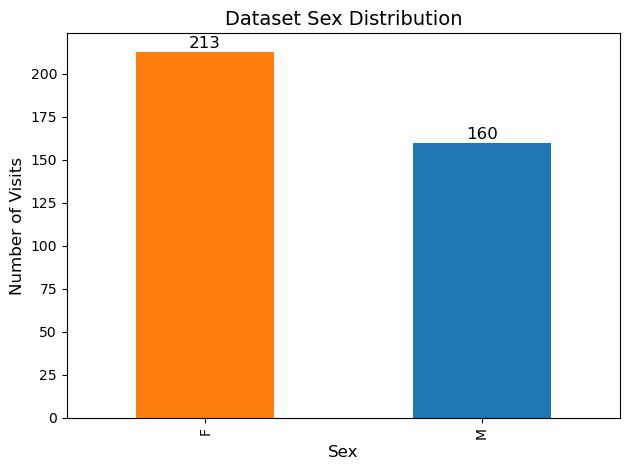

In [60]:
# Visualise sex distribution of data

counts = df_clean['M/F'].value_counts()
colours = ['tab:blue' if sex == 'M' else 'tab:orange' for sex in counts.index]
ax = counts.plot(kind='bar', color=colours)
for i, val in enumerate(counts):
    ax.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Number of Visits', fontsize=12)
ax.set_xlabel('Sex', fontsize=12)
ax.set_title('Dataset Sex Distribution', fontsize=14)
plt.tight_layout()
plt.show()


## Repeated Train/Test Evaluation Function

In [62]:

# === REPEATED TRAIN/TEST EVALUATION ===

def repeated_evaluation(model, X, y, label, sex=None, sex_filter=None, groups=None, n_splits=5, n_repeats=5):
    fold_metrics = []
    for repeat in range(n_repeats):
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED + repeat)
        for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            scaler = StandardScaler() 
            X_train_scaled = scaler.fit_transform(X_train) 
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled) [:, 1]
        if sex is not None and sex_filter is not None:
            test_sex = sex.iloc[test_idx]
            mask = test_sex == sex_filter
            if not mask.any():
                continue
            y_test = y_test[mask]
            y_pred = y_pred[mask]
            y_proba = y_proba[mask]

        fold_metrics.append({
            'repeat': repeat,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        })

    metrics_df = pd.DataFrame(fold_metrics)
    metrics = metrics_df[['accuracy', 'balanced_accuracy','f1', 'precision', 'recall', 'roc_auc']]
    means = metrics.mean()
    stds = metrics.std()
    summary = [
        label,
        means['accuracy'], stds['accuracy'],
        means['balanced_accuracy'], stds['balanced_accuracy'],
        means['f1'], stds['f1'],
        means['precision'], stds['precision'],
        means['recall'], stds['recall'],
        means['roc_auc'], stds['roc_auc']
    ]
   
    return summary, metrics_df

In [63]:

X_all = df_clean[my_features]
y_all = df_clean['Group']
sex_all = df_clean['M/F']
groups_all = df_clean['Subject ID']

## Logistic Regression and Random Forest Classifier Models

In [65]:

# === General LR models ===
LR_RF_results = []
results_folds = {}

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-All", groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-All"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-M", sex=sex_all, sex_filter='M', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-F", sex=sex_all, sex_filter='F', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-F"] = folds


In [66]:
# === General RF models ===

summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-All", groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-All"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-M", sex=sex_all, sex_filter='M', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-M"] = folds
summary, fold = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-F", sex=sex_all, sex_filter='F', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-F"] = folds

In [67]:

# === Sex specific models ===

df_male = df_clean[df_clean['M/F'] == 'M']
df_female = df_clean[df_clean['M/F'] == 'F']
groups_f = df_female['Subject ID']
groups_m = df_male['Subject ID']

X_m, y_m = df_male[my_features], df_male['Group']
X_f, y_f = df_female[my_features], df_female['Group']


summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_m, y_m, "Male-LR-M", groups=groups_m)
LR_RF_results.append(summary)
results_folds["Male-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_f, y_f, "Female-LR-F", groups=groups_f)
LR_RF_results.append(summary)
results_folds["Female-LR-F"] = folds


summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_m, y_m, "Male-RF-M", groups=groups_m)
LR_RF_results.append(summary)
results_folds["Male-RF-M"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_f, y_f, "Female-RF-F", groups=groups_f)
LR_RF_results.append(summary)
results_folds["Female-RF-F"] = folds

In [68]:

# === Results Table ===
columns =['Model', 'Accuracy_mean', 'Accuracy_std', 'BalancedAccuracy_mean', 'BalancedAccuracy_std', 'F1_mean', 'F1_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'AUC_mean', 'AUC_std']
results_table = pd.DataFrame(LR_RF_results, columns=columns)
n_splits, n_repeats = 5, 5
metrics = ['Accuracy', 'BalancedAccuracy', 'F1', 'Precision', 'Recall', 'AUC']
N = n_splits * n_repeats
for metric in metrics:
    se = results_table[f'{metric}_std'] / np.sqrt(N)
    results_table[f'{metric}_ci_lower'] = results_table[f'{metric}_mean'] - 1.96 * se
    results_table[f'{metric}_ci_upper'] = results_table[f'{metric}_mean'] + 1.96 * se
print(results_table)


         Model  Accuracy_mean  Accuracy_std  BalancedAccuracy_mean  \
0   Gen-LR-All       0.940433      0.015127               0.940335   
1     Gen-LR-M       0.965453      0.013011               0.969613   
2     Gen-LR-F       0.918739      0.027483               0.877570   
3   Gen-RF-All       0.945530      0.017214               0.944307   
4     Gen-RF-M       0.960190      0.014124               0.959613   
5     Gen-RF-F       0.932655      0.032698               0.895509   
6    Male-LR-M       0.970289      0.038332               0.976267   
7  Female-LR-F       0.959723      0.039251               0.931656   
8    Male-RF-M       0.930390      0.047504               0.928843   
9  Female-RF-F       0.936847      0.030709               0.912172   

   BalancedAccuracy_std   F1_mean    F1_std  Precision_mean  Precision_std  \
0              0.015590  0.935406  0.018655        0.986406       0.018655   
1              0.017722  0.973939  0.010982        0.982213       0.02436

## XGBOOST models

In [70]:
xgb_results = []
xgb_fold_results = {}
xgb_model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-All', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-All'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-M', sex=sex_all, sex_filter='M', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-F', sex=sex_all, sex_filter='F', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-F'] = folds

summary, folds = repeated_evaluation(xgb_model, X_m, y_m, 'Male-XGB-M', groups=groups_m)
xgb_results.append(summary)                  
xgb_fold_results['Male-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_f, y_f, 'Female-XGB-F', groups=groups_f)
xgb_results.append(summary)                  
xgb_fold_results['Female-XGB-F'] = folds


In [71]:
xgb_results_table = pd.DataFrame(xgb_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = xgb_results_table[f'{metric}_std'] / np.sqrt(N)
    xgb_results_table[f'{metric}_ci_lower'] = xgb_results_table[f'{metric}_mean'] - 1.96 * se
    xgb_results_table[f'{metric}_ci_upper'] = xgb_results_table[f'{metric}_mean'] + 1.96 * se
print(xgb_results_table)

          Model  Accuracy_mean  Accuracy_std  BalancedAccuracy_mean  \
0   Gen-XGB-All       0.940637      0.033243               0.941552   
1     Gen-XGB-M       0.947964      0.037605               0.944228   
2     Gen-XGB-F       0.932364      0.053914               0.902044   
3    Male-XGB-M       0.958673      0.035301               0.963351   
4  Female-XGB-F       0.913392      0.032533               0.882451   

   BalancedAccuracy_std   F1_mean    F1_std  Precision_mean  Precision_std  \
0              0.036253  0.934190  0.044696        0.956288       0.054158   
1              0.050807  0.961388  0.028790        0.957609       0.051041   
2              0.084930  0.875929  0.115393        0.949206       0.070452   
3              0.028810  0.966515  0.027974        0.971292       0.041575   
4              0.033924  0.867011  0.028357        0.913621       0.088210   

   Recall_mean  ...  BalancedAccuracy_ci_lower  BalancedAccuracy_ci_upper  \
0     0.913946  ...        

## Support Vector Machine and Voting Classifier Models 

In [73]:
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)

svm_vote_results = []
svm_vote_fold_results = {}

# === SVM general models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-All'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-M'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-F'] = folds

# === SVM sex-specific models ===
summary, folds = repeated_evaluation(svm_model, X_m, y_m, 'Male-SVM-M', groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-SVM-M'] = folds

summary, folds = repeated_evaluation(svm_model, X_f, y_f, 'Female-SVM-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-SVM-F'] = folds

In [74]:
# === Voting Classifier Set-up ===

voting_estimators =[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)),
]
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

In [75]:
# === VC general models ===

summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-All'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-F'] = folds
                                         
# === VC sex-specific models
summary, folds = repeated_evaluation(voting_clf, X_m, y_m, 'Male-VC-M',  groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-VC-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_f, y_f, 'Female-VC-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-VC-F'] = folds


In [76]:
# === SVM and VC results ===

svm_vote_results_table = pd.DataFrame(svm_vote_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = svm_vote_results_table[f'{metric}_std'] / np.sqrt(N)
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] - 1.96 * se
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] + 1.96 * se
print(svm_vote_results_table)

          Model  Accuracy_mean  Accuracy_std  BalancedAccuracy_mean  \
0   Gen-SVM-All       0.937801      0.017447               0.937954   
1     Gen-SVM-M       0.965453      0.013011               0.969613   
2     Gen-SVM-F       0.913333      0.035556               0.873570   
3    Male-SVM-M       0.969595      0.054160               0.977972   
4  Female-SVM-F       0.954845      0.034183               0.921656   
5    Gen-VC-All       0.940433      0.015127               0.940335   
6      Gen-VC-M       0.965453      0.013011               0.969613   
7      Gen-VC-F       0.918739      0.027483               0.877570   
8     Male-VC-M       0.975845      0.040627               0.982517   
9   Female-VC-F       0.954845      0.034183               0.928430   

   BalancedAccuracy_std   F1_mean    F1_std  Precision_mean  Precision_std  \
0              0.018364  0.932609  0.021757        0.980357       0.028516   
1              0.017722  0.973939  0.010982        0.982213   

## Visually Assessing Model Accuracies - Initial Look

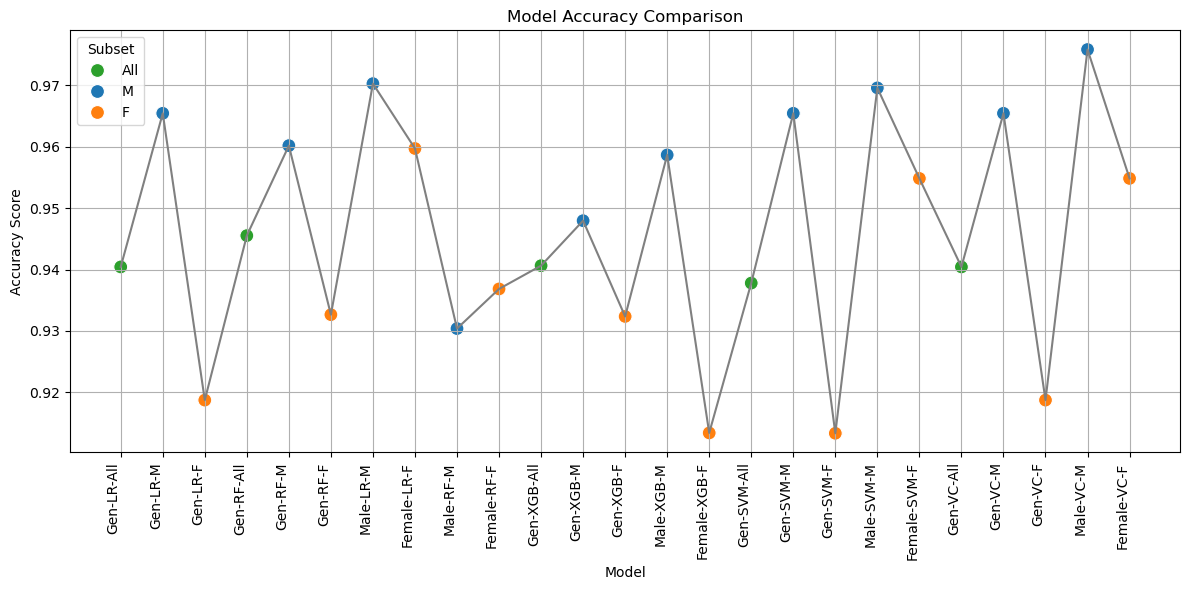

In [78]:
all_results_table = pd.concat([results_table, xgb_results_table, svm_vote_results_table], ignore_index=True)
all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['Accuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='Accuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

In [79]:
# Report mean balanced accuracy for each model
metric = "balanced_accuracy"
all_fold_tables = []
for results in (results_folds, xgb_fold_results, svm_vote_fold_results):
    for model_name, fold_df in results.items():
        df = fold_df.copy()
        df['Model'] = model_name
        all_fold_tables.append(df)

fold_metrics = pd.concat(all_fold_tables, ignore_index=True)

In [80]:
summary = fold_metrics.groupby('Model')[metric].agg(['mean', 'std'])
for model_name, row in summary.iterrows():
    print(f"{model_name}: {row['mean']:.4f} ± {row['std']:.4f}")

Female-LR-F: 0.9317 ± 0.0699
Female-RF-F: 0.9122 ± 0.0593
Female-SVM-F: 0.9217 ± 0.0607
Female-VC-F: 0.9284 ± 0.0663
Female-XGB-F: 0.8825 ± 0.0339
Gen-LR-All: 0.9403 ± 0.0156
Gen-LR-F: 0.8776 ± 0.0431
Gen-LR-M: 0.9696 ± 0.0177
Gen-RF-All: 0.9443 ± 0.0190
Gen-RF-F: 0.9596 ± 0.0224
Gen-RF-M: 0.9596 ± 0.0224
Gen-SVM-All: 0.9380 ± 0.0184
Gen-SVM-F: 0.8736 ± 0.0487
Gen-SVM-M: 0.9696 ± 0.0177
Gen-VC-All: 0.9403 ± 0.0156
Gen-VC-F: 0.8776 ± 0.0431
Gen-VC-M: 0.9696 ± 0.0177
Gen-XGB-All: 0.9416 ± 0.0363
Gen-XGB-F: 0.9020 ± 0.0849
Gen-XGB-M: 0.9442 ± 0.0508
Male-LR-M: 0.9763 ± 0.0282
Male-RF-M: 0.9288 ± 0.0515
Male-SVM-M: 0.9780 ± 0.0394
Male-VC-M: 0.9825 ± 0.0295
Male-XGB-M: 0.9634 ± 0.0288


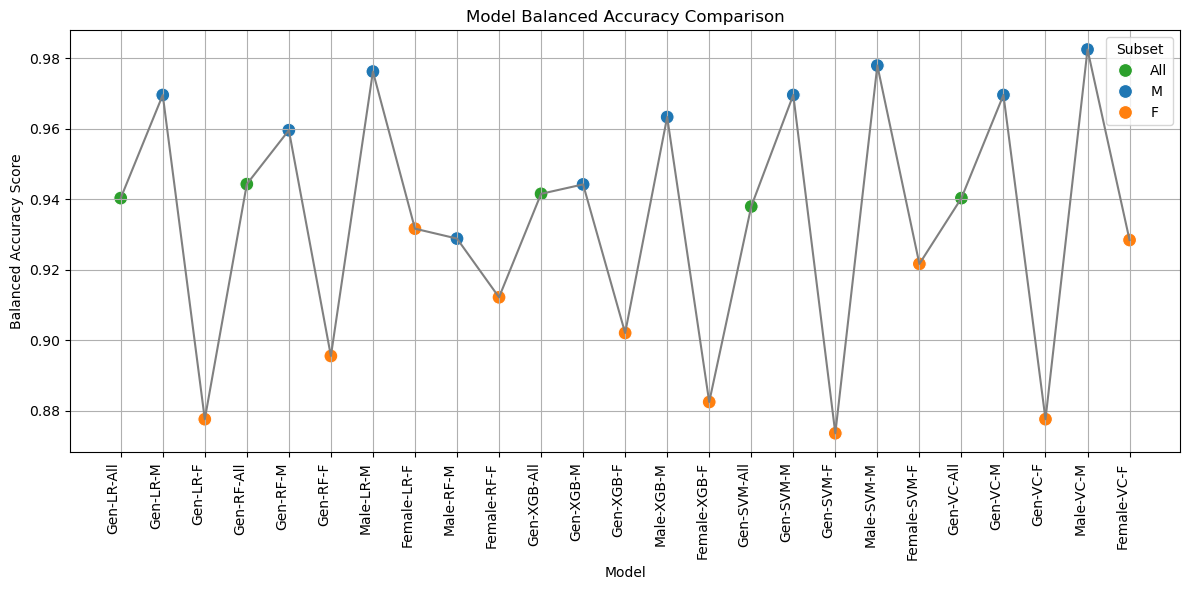

In [81]:
# Displaying Balanced Accuracy  

all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['BalancedAccuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='BalancedAccuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Balanced Accuracy Score')
plt.title('Model Balanced Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

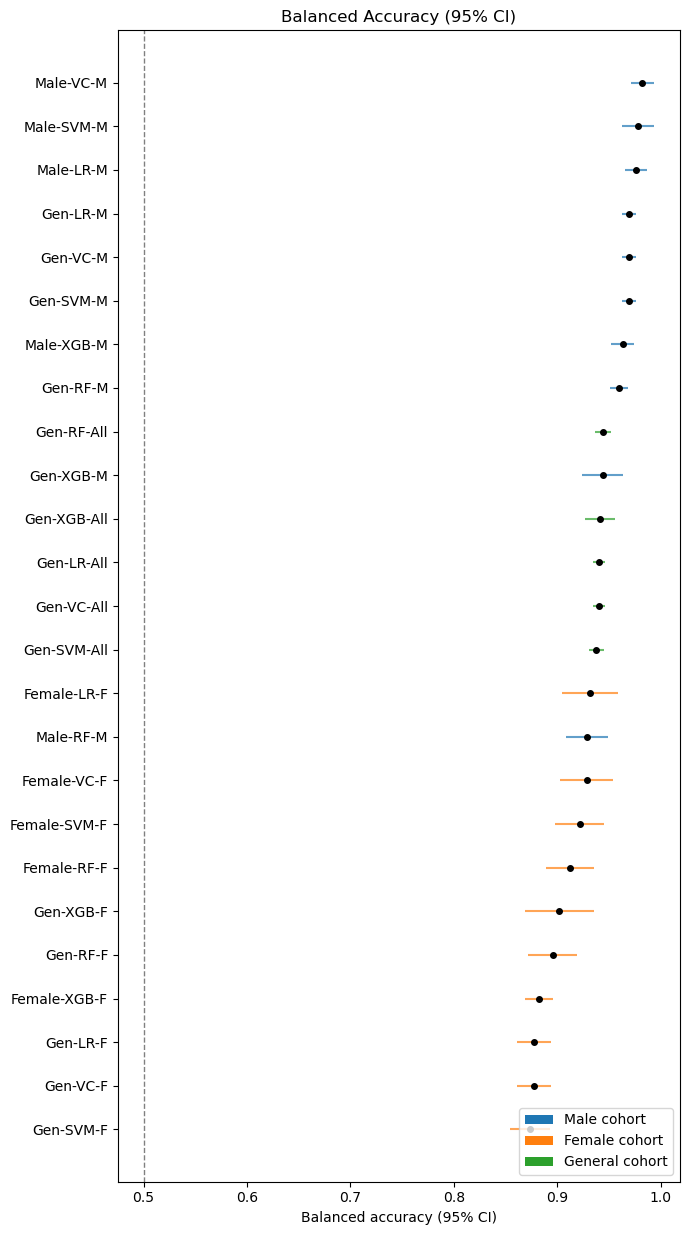

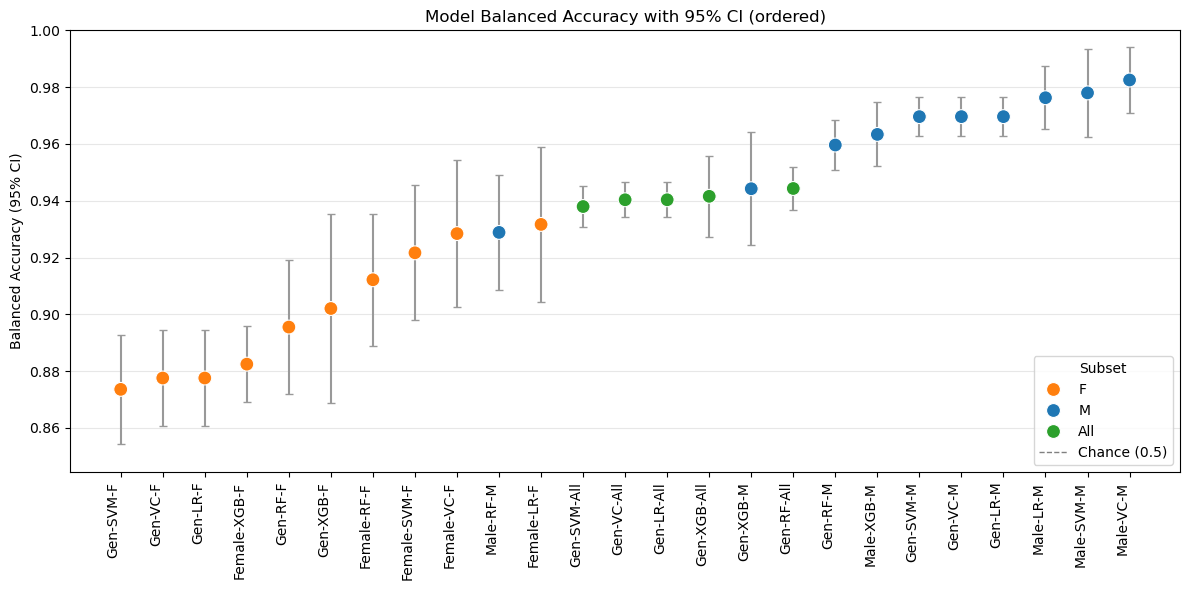

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = all_results_table.copy()
# Derive cohort (last token: M / F / All)
df['Subset'] = df['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}

N_REPEATS = 25 

if isinstance(N_REPEATS, int) and N_REPEATS > 1:
    sem = df['BalancedAccuracy_std'] / np.sqrt(N_REPEATS)
    ci = 1.96 * sem
    df['err_lo'] = df['BalancedAccuracy_mean'] - ci
    df['err_hi'] = df['BalancedAccuracy_mean'] + ci
    err_label = "95% CI"
else:
    df['err_lo'] = df['BalancedAccuracy_mean'] - df['BalancedAccuracy_std']
    df['err_hi'] = df['BalancedAccuracy_mean'] + df['BalancedAccuracy_std']
    err_label = "± SD"

# Keep bounds sensible
df[['err_lo','err_hi']] = df[['err_lo','err_hi']].clip(0, 1)

# === Order models by mean (improves readability) ===
order = df.sort_values('BalancedAccuracy_mean')['Model'].tolist()
df_ord = df.set_index('Model').loc[order].reset_index()

# Map categories to x positions
x = np.arange(len(df_ord))

plt.figure(figsize=(12, 6))

# Error bars first (so points draw on top)
for i, r in df_ord.iterrows():
    y = r['BalancedAccuracy_mean']
    ylo = r['err_lo']; yhi = r['err_hi']
    plt.errorbar(i, y,
                 yerr=[[y - ylo], [yhi - y]],
                 fmt='none', ecolor='0.6', elinewidth=1.5, capsize=3, zorder=2)

# Scatter points colored by cohort
sns.scatterplot(x=x, y=df_ord['BalancedAccuracy_mean'],
                hue=df_ord['Subset'], palette=palette, s=100, zorder=3)

# Cosmetics
plt.axhline(0.5, ls='--', c='gray', lw=1, label='Chance (0.5)')
plt.xticks(x, df_ord['Model'], rotation=90, ha='right')
plt.ylabel(f'Balanced Accuracy ({err_label})')
plt.title('Model Balanced Accuracy with 95% CI (ordered)')
# Zoom y-axis to the data range for clarity
ymin = max(0.5, float(df_ord['err_lo'].min()) - 0.01)
ymax = min(1.0, float(df_ord['err_hi'].max()) + 0.01)
plt.ylim(ymin, ymax)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.legend(title='Subset', loc='lower right')
plt.show()
plt.savefig("Bacc_final.pdf", bbox_inches="tight")
plt.close()

In [92]:
import pandas as pd
import numpy as np

# ===== Display options so the table doesn't wrap/truncate =====
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
pd.set_option("display.colheader_justify", "center")

def make_metrics_table(
    df: pd.DataFrame,
    include_std: bool = False,            # set True to show "mean ± SD" columns if *_std exist
    sort_by: str = "BalancedAccuracy_mean",
    ascending: bool = False,              # sort high→low by default
    add_subset: bool = True               # add a Subset (All/M/F) column from model name suffix
) -> pd.DataFrame:
    d = df.copy()

    # Optional: derive Subset from model name suffix (-M / -F / -All)
    if add_subset:
        d["Subset"] = d["Model"].str.split("-").str[-1]
        # Order Subset for readability: All, M, F
        d["Subset"] = pd.Categorical(d["Subset"], categories=["All","M","F"], ordered=True)

    # Columns we want
    base_cols = ["Model", "BalancedAccuracy_mean", "F1_mean", "Precision_mean", "Recall_mean"]
    if add_subset:
        base_cols = ["Model", "Subset"] + base_cols[1:]
    d = d[base_cols].copy()

    if include_std:
        # If std columns exist, combine as "mean ± SD"
        for m in ["BalancedAccuracy", "F1", "Precision", "Recall"]:
            mean_col = f"{m}_mean"
            std_col  = f"{m}_std"
            if std_col in df.columns:
                d[m] = [f"{mu:.3f} ± {sd:.3f}" for mu, sd in zip(df[mean_col], df[std_col])]
            else:
                d[m] = [f"{mu:.3f}" for mu in df[mean_col]]
        keep = ["Model"] + (["Subset"] if add_subset else []) + ["BalancedAccuracy","F1","Precision","Recall"]
        d = d[keep]
        # Sorting uses mean even if we're displaying "± SD"
        sort_series = df[sort_by]
    else:
        # Round means to 3 d.p. for readability
        for c in ["BalancedAccuracy_mean", "F1_mean", "Precision_mean", "Recall_mean"]:
            d[c] = d[c].astype(float).round(3)
        sort_series = df[sort_by]

    # Sort rows
    d = d.iloc[sort_series.sort_values(ascending=ascending).index]

    # Print a plain (ugly) text table
    print(d.to_string(index=False))

    return d

# ====== Use it ======
# Means only (plain numbers)
_ = make_metrics_table(all_results_table, include_std=False)

# Or, show "mean ± SD" (if you have BalancedAccuracy_std, F1_std, etc.)
# _ = make_metrics_table(all_results_table, include_std=True)


   Model     Subset  BalancedAccuracy_mean  F1_mean  Precision_mean  Recall_mean
   Male-VC-M    M           0.983           0.981        1.000         0.965    
  Male-SVM-M    M           0.978           0.976        1.000         0.956    
   Male-LR-M    M           0.976           0.977        0.990         0.965    
   Gen-SVM-M    M           0.970           0.974        0.982         0.966    
    Gen-VC-M    M           0.970           0.974        0.982         0.966    
    Gen-LR-M    M           0.970           0.974        0.982         0.966    
  Male-XGB-M    M           0.963           0.967        0.971         0.965    
    Gen-RF-M    M           0.960           0.970        0.975         0.966    
  Gen-RF-All  All           0.944           0.941        0.982         0.904    
   Gen-XGB-M    M           0.944           0.961        0.958         0.966    
 Gen-XGB-All  All           0.942           0.934        0.956         0.914    
  Gen-LR-All  All           